In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as Func
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from tqdm import tqdm
from collections import Counter
from PIL import Image
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
data_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [4]:
class BrainDataset(Dataset):
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels

        if augmentations is None:
            self.augmentations = v2.Compose([
                v2.Resize((224, 224)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.labels[index]
        sample = Image.open(self.paths[index]).convert("L")
        sample = self.augmentations(sample)

        return (sample, torch.tensor(label, dtype=torch.float))

In [5]:
label2idx = {
    "glioma": 0,
    "meningioma": 1,
    "notumor": 2,
    "pituitary": 3
}

idx2label = {
    0: "glioma",
    1: "meningioma",
    2: "notumor",
    3: "pituitary"
}

In [6]:
train_dataset_path = "./data/brain_tumor_2/Training"
test_dataset_path = "./data/brain_tumor_2/Testing/"

train_paths = []
train_labels = []
test_paths = []
test_labels = []

for label in ["glioma", "meningioma", "notumor", "pituitary"]:
    for dirname, _, filenames in os.walk(os.path.join(train_dataset_path, label)):
        for filename in filenames:
            train_paths.append(os.path.join(dirname, filename))
            train_labels.append(label2idx[label])

    for dirname, _, filenames in os.walk(os.path.join(test_dataset_path, label)):
        for filename in filenames:
            test_paths.append(os.path.join(dirname, filename))
            test_labels.append(label2idx[label])

In [7]:
batch_size_train_cls = 64
batch_size_test = 64
batch_size_train_mem = 128

In [8]:
train_dataset = BrainDataset(train_paths, train_labels, augmentations=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train_cls, shuffle=True)
val_dataset = BrainDataset(test_paths, test_labels, augmentations=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=False)

In [9]:
mem_dataset_temp = ImageFolder("./data/brain_tumor_2/Training/", 
                               transform=v2.Compose([
                                   v2.Resize((224, 224)),
                                   v2.ToImage(),
                                   v2.ToDtype(torch.float32, scale=True)
                               ]))

In [10]:
temp_data = [img[0] for img in mem_dataset_temp.imgs]
temp_targets = mem_dataset_temp.targets

In [11]:
# stratify split to chunks

from collections import defaultdict

n_chunks = 10

class_indices = defaultdict(list)
for idx, target in enumerate(temp_targets):
    class_indices[target].append(idx)

for key in class_indices:
    class_indices[key].sort()

chunk_size = len(temp_data) // n_chunks

chunks = [[] for _ in range(n_chunks)]

for key, indices in class_indices.items():
    chunked_indices = np.array_split(indices, n_chunks)
    for i in range(n_chunks):
        chunks[i].extend(chunked_indices[i])

for chunk in chunks:
    chunk.sort()

mem_data_chunks = []

for chunk in chunks:
    paths = []
    targets = []
    for idx in chunk:
        paths.append(train_paths[idx])
        targets.append(train_labels[idx])
    mem_data_chunks.append((paths, targets))

In [12]:
def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)   
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]	
        i -= 1
    return gray

In [13]:
class BrainMemData(Dataset):
    def __init__(self, mem_data_chunk, num_classes, device):
        self.paths = mem_data_chunk[0]
        self.targets = mem_data_chunk[1]
        self.device = device
        self.num_classes = num_classes
        self.bitlength = num_classes
        self.augmentation = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        self.C = Counter()
        self.cbinIndexes = np.zeros((len(self.targets), self.bitlength))
        self.inputs = []
        self.input2index = {}

        with torch.no_grad():
            for i in range(len(self.paths)):
                label = int(self.targets[i])
                self.C.update(str(label))
                class_code = torch.zeros(self.num_classes)
                class_code[int(self.targets[i])] = 3
                self.cbinIndexes[i] = grayN(3, num_classes, self.C[str(label)]) +  class_code  # Gray Code with OHE class code

                input = torch.tensor(self.cbinIndexes[i]).float()
                self.inputs.append( input )
                self.input2index[( label, self.C[str(label)] )] = i

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        target = int(self.targets[index])
        label = torch.zeros(self.num_classes).float()
        label[target] = 1
        img = Image.open(self.paths[index]).convert("L")
        img = self.augmentation(img) # resize to (224, 224)
        return self.inputs[index].to(self.device), label.to(self.device), img.to(self.device)

In [14]:
# random permutation for each chnnks
chunks = []
for mem_data_chunk in mem_data_chunks:
    if len(mem_data_chunk[0]) != len(mem_data_chunk[1]):
        raise ValueError("Data and Label must have the same length")

    indices = list(range(len(mem_data_chunk[0])))

    random.shuffle(indices)

    shuffled_data = [mem_data_chunk[0][i] for i in indices]
    shuffled_targets = [mem_data_chunk[1][i] for i in indices]

    chunks.append((shuffled_data, shuffled_targets))

In [15]:
train_mem_dataset = BrainMemData(mem_data_chunk=chunks[0], num_classes=4, device=device)
train_mem_dataloader = DataLoader(train_mem_dataset, batch_size=batch_size_train_mem, shuffle=False)

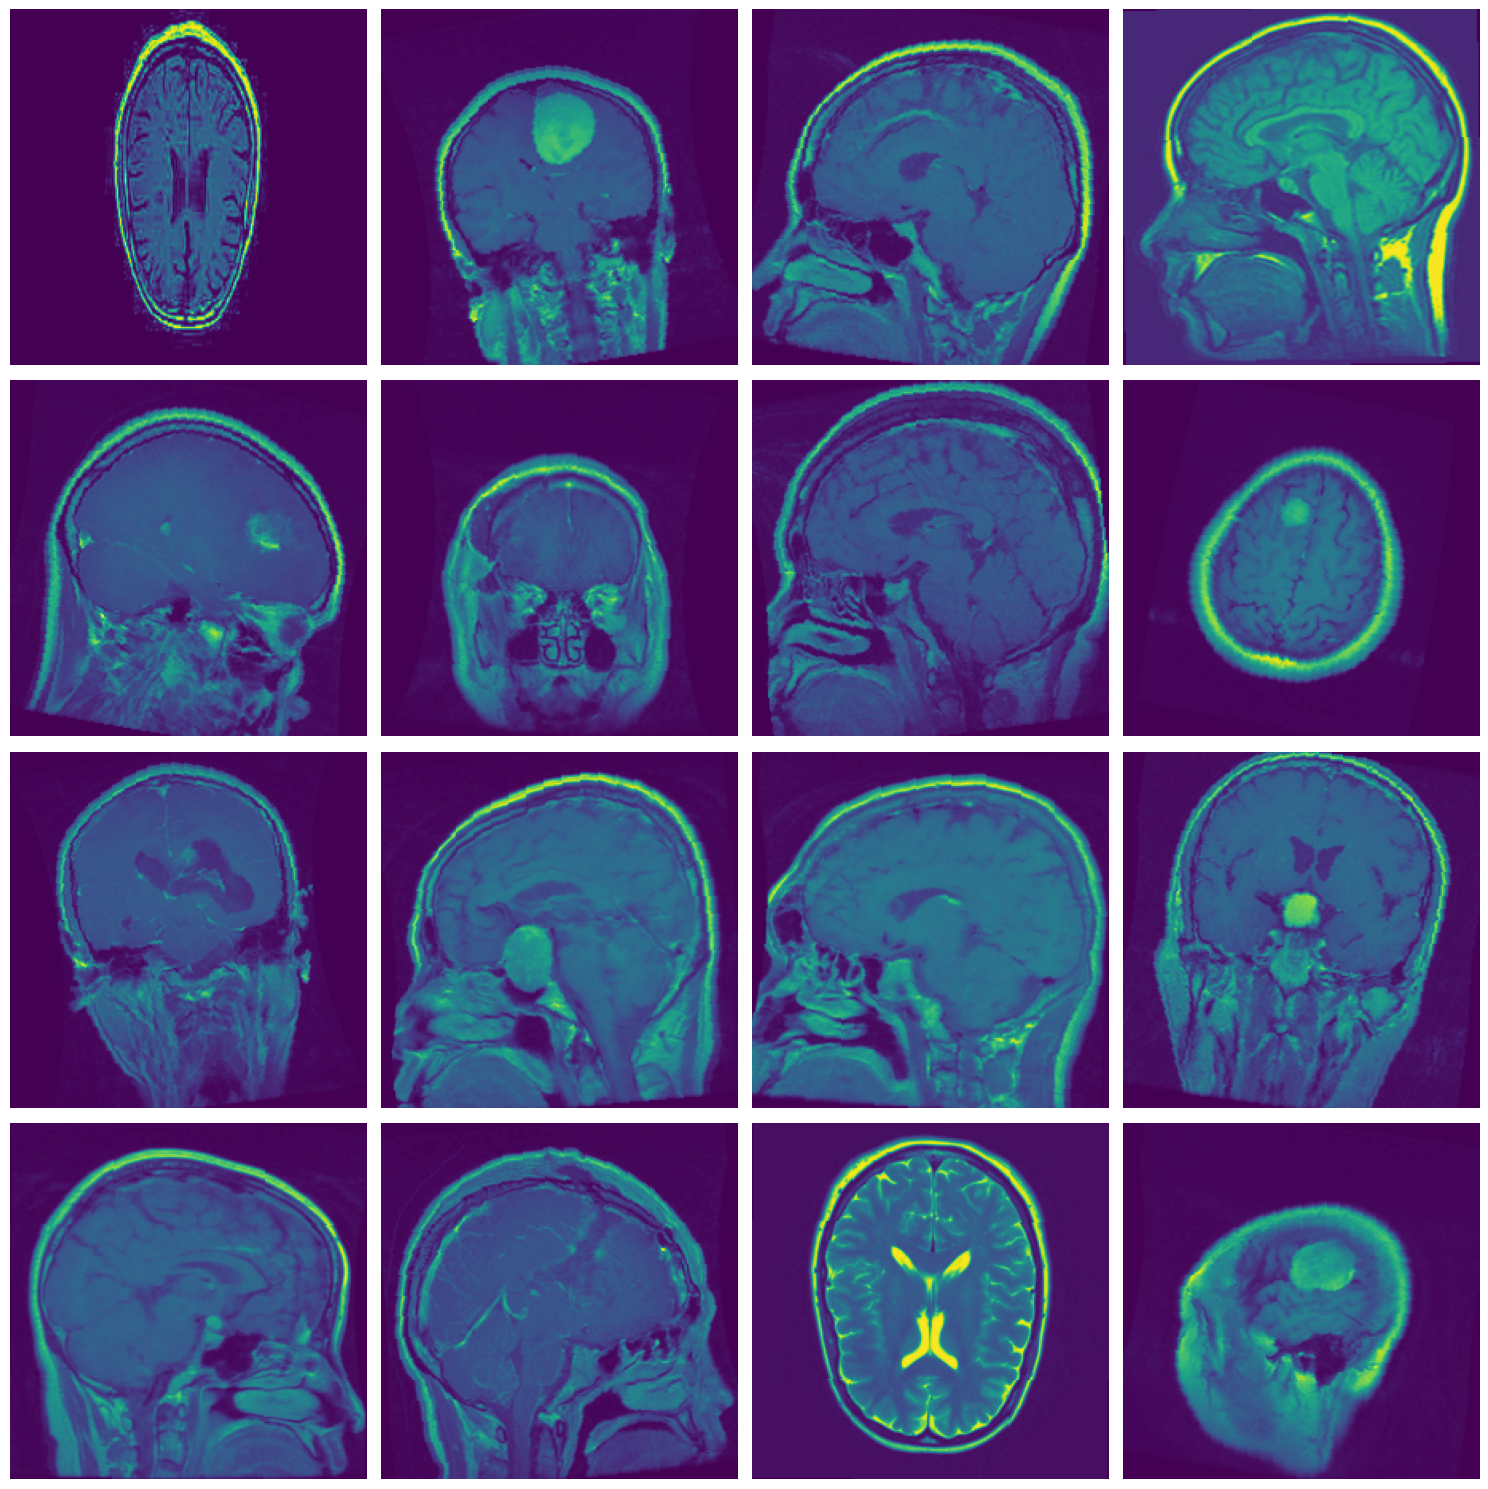

In [16]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1))).clip(0, 1)

# Create a grid of images
num_images = 16
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        # ax.set_title(f'Label: {idx2label[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def forward_transposed(self, code):
        # classfier layers
        code = torch.matmul(code, self.classifier[2].weight)
        code = torch.relu(code)
        code = torch.matmul(code, self.classifier[0].weight)
        # feature layers
        code = code.view(code.size(0), 32, 56, 56)
        code = F.interpolate(code, scale_factor=2, recompute_scale_factor=False, mode='nearest')
        code = torch.relu(code)
        code = F.conv_transpose2d(code, self.features[3].weight.data, padding=1)
        code = F.interpolate(code, scale_factor=2, recompute_scale_factor=False, mode='nearest')
        code = torch.relu(code)
        code = F.conv_transpose2d(code, self.features[0].weight.data, padding=1)
        return code

model = TumorClassifier(num_classes=4)
model = model.to(device)

In [18]:
loss_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model.parameters(), lr=0.001)

loss_mem = nn.MSELoss()
optimizer_mem = optim.AdamW(model.parameters(), lr=1e-3)

In [19]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [20]:
# Training loop
num_epochs = 100
best_val_accuracy = 0.0

epoch = 0
for epoch in range(num_epochs):
    model.train()
    loss_c = 0
    loss_r = 0
    c = 0
    mem_iter = iter(train_mem_dataloader)
    
    for (inputs, labels) in tqdm(train_loader):
        try:
            (code, _, imgs) = next(mem_iter)
        except:
            mem_iter = iter(train_mem_dataloader)
            (code, _, imgs) = next(mem_iter)
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        code = code.to(device)
        imgs = imgs.to(device)
        
        optimizer_cls.zero_grad()
        optimizer_mem.zero_grad()
        outputs = model(inputs)
        loss_classf = loss_cls(outputs, labels)
        loss_classf.backward()
        optimizer_cls.step()

        optimizer_mem.zero_grad()
        optimizer_cls.zero_grad()
        predimg = model.forward_transposed(code)
        loss_recon = loss_mem(predimg, imgs)
        loss_recon.backward()
        optimizer_mem.step()
        
        loss_c += loss_classf.item()
        loss_r += loss_recon.item()
        c += 1

    print("epoch: {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, num_epochs, loss_c/c, loss_r/c))
    
    # # Save the best model
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     torch.save(model.state_dict(), 'best_model.pth')

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:35<00:00,  1.06s/it]


epoch: 1/100, loss_c = 0.782989, loss_r = 0.027198


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 2/100, loss_c = 0.480315, loss_r = 0.022906


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:15<00:00,  1.19it/s]


epoch: 3/100, loss_c = 0.384075, loss_r = 0.022379


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 4/100, loss_c = 0.339803, loss_r = 0.022162


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:15<00:00,  1.19it/s]


epoch: 5/100, loss_c = 0.289452, loss_r = 0.021931


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 6/100, loss_c = 0.241530, loss_r = 0.021342


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:15<00:00,  1.19it/s]


epoch: 7/100, loss_c = 0.192571, loss_r = 0.020956


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 8/100, loss_c = 0.164275, loss_r = 0.020685


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:21<00:00,  1.10it/s]


epoch: 9/100, loss_c = 0.160655, loss_r = 0.020443


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 10/100, loss_c = 0.127307, loss_r = 0.020139


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 11/100, loss_c = 0.120510, loss_r = 0.019885


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 12/100, loss_c = 0.101659, loss_r = 0.019621


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 13/100, loss_c = 0.082170, loss_r = 0.019417


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 14/100, loss_c = 0.090361, loss_r = 0.019267


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 15/100, loss_c = 0.073479, loss_r = 0.019098


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 16/100, loss_c = 0.066506, loss_r = 0.018864


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 17/100, loss_c = 0.061947, loss_r = 0.018726


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 18/100, loss_c = 0.054287, loss_r = 0.018550


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 19/100, loss_c = 0.040192, loss_r = 0.018410


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 20/100, loss_c = 0.062789, loss_r = 0.018547


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 21/100, loss_c = 0.043304, loss_r = 0.018121


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 22/100, loss_c = 0.039999, loss_r = 0.017805


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 23/100, loss_c = 0.032549, loss_r = 0.017671


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 24/100, loss_c = 0.030195, loss_r = 0.017501


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.15it/s]


epoch: 25/100, loss_c = 0.033555, loss_r = 0.017334


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 26/100, loss_c = 0.030515, loss_r = 0.017287


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 27/100, loss_c = 0.033690, loss_r = 0.017206


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 28/100, loss_c = 0.021473, loss_r = 0.017045


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 29/100, loss_c = 0.025608, loss_r = 0.016917


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:20<00:00,  1.12it/s]


epoch: 30/100, loss_c = 0.019610, loss_r = 0.016744


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 31/100, loss_c = 0.023085, loss_r = 0.016637


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 32/100, loss_c = 0.019675, loss_r = 0.016539


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 33/100, loss_c = 0.021284, loss_r = 0.016397


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 34/100, loss_c = 0.029327, loss_r = 0.016405


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:19<00:00,  1.13it/s]


epoch: 35/100, loss_c = 0.019212, loss_r = 0.016331


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 36/100, loss_c = 0.024283, loss_r = 0.016239


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 37/100, loss_c = 0.011754, loss_r = 0.016087


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 38/100, loss_c = 0.013403, loss_r = 0.016054


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 39/100, loss_c = 0.029308, loss_r = 0.016181


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 40/100, loss_c = 0.024400, loss_r = 0.016067


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 41/100, loss_c = 0.034037, loss_r = 0.015967


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 42/100, loss_c = 0.017795, loss_r = 0.015718


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.14it/s]


epoch: 43/100, loss_c = 0.011886, loss_r = 0.015491


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 44/100, loss_c = 0.011967, loss_r = 0.015444


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 45/100, loss_c = 0.013245, loss_r = 0.015399


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 46/100, loss_c = 0.015597, loss_r = 0.015378


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 47/100, loss_c = 0.009195, loss_r = 0.015300


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 48/100, loss_c = 0.013421, loss_r = 0.015255


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 49/100, loss_c = 0.025464, loss_r = 0.015397


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 50/100, loss_c = 0.010858, loss_r = 0.015230


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 51/100, loss_c = 0.018243, loss_r = 0.015122


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 52/100, loss_c = 0.009534, loss_r = 0.015037


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:42<00:00,  1.14s/it]


epoch: 53/100, loss_c = 0.016517, loss_r = 0.015138


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:24<00:00,  1.07it/s]


epoch: 54/100, loss_c = 0.018857, loss_r = 0.015091


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 55/100, loss_c = 0.031247, loss_r = 0.015407


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 56/100, loss_c = 0.016018, loss_r = 0.015079


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 57/100, loss_c = 0.013735, loss_r = 0.014818


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 58/100, loss_c = 0.005170, loss_r = 0.014677


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 59/100, loss_c = 0.006534, loss_r = 0.014622


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 60/100, loss_c = 0.019586, loss_r = 0.014761


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 61/100, loss_c = 0.014964, loss_r = 0.014821


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 62/100, loss_c = 0.006249, loss_r = 0.014644


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 63/100, loss_c = 0.005977, loss_r = 0.014510


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 64/100, loss_c = 0.005206, loss_r = 0.014441


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 65/100, loss_c = 0.005706, loss_r = 0.014369


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 66/100, loss_c = 0.011560, loss_r = 0.014444


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 67/100, loss_c = 0.006566, loss_r = 0.014405


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 68/100, loss_c = 0.017083, loss_r = 0.014658


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 69/100, loss_c = 0.013734, loss_r = 0.014568


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 70/100, loss_c = 0.008154, loss_r = 0.014348


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 71/100, loss_c = 0.036982, loss_r = 0.014660


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 72/100, loss_c = 0.024773, loss_r = 0.015026


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:26<00:00,  1.04it/s]


epoch: 73/100, loss_c = 0.033325, loss_r = 0.015344


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:21<00:00,  1.10it/s]


epoch: 74/100, loss_c = 0.033814, loss_r = 0.015006


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:35<00:00,  1.06s/it]


epoch: 75/100, loss_c = 0.009405, loss_r = 0.014430


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:33<00:00,  1.04s/it]


epoch: 76/100, loss_c = 0.006321, loss_r = 0.014240


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:22<00:00,  1.09it/s]


epoch: 77/100, loss_c = 0.003969, loss_r = 0.014213


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 78/100, loss_c = 0.007834, loss_r = 0.014265


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.15it/s]


epoch: 79/100, loss_c = 0.005204, loss_r = 0.014161


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 80/100, loss_c = 0.004756, loss_r = 0.014004


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 81/100, loss_c = 0.004859, loss_r = 0.013972


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 82/100, loss_c = 0.005025, loss_r = 0.014010


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.17it/s]


epoch: 83/100, loss_c = 0.006341, loss_r = 0.014106


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 84/100, loss_c = 0.004034, loss_r = 0.014019


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 85/100, loss_c = 0.005327, loss_r = 0.013992


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 86/100, loss_c = 0.002530, loss_r = 0.013871


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 87/100, loss_c = 0.002918, loss_r = 0.013849


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:17<00:00,  1.16it/s]


epoch: 88/100, loss_c = 0.004145, loss_r = 0.013886


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:18<00:00,  1.14it/s]


epoch: 89/100, loss_c = 0.001474, loss_r = 0.013831


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:22<00:00,  1.10it/s]


epoch: 90/100, loss_c = 0.002551, loss_r = 0.013850


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [02:04<00:00,  1.38s/it]


epoch: 91/100, loss_c = 0.002591, loss_r = 0.013804


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:58<00:00,  1.32s/it]


epoch: 92/100, loss_c = 0.010968, loss_r = 0.013932


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:15<00:00,  1.19it/s]


epoch: 93/100, loss_c = 0.026227, loss_r = 0.014563


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 94/100, loss_c = 0.030290, loss_r = 0.014505


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 95/100, loss_c = 0.005294, loss_r = 0.013905


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]


epoch: 96/100, loss_c = 0.007089, loss_r = 0.013880


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 97/100, loss_c = 0.003551, loss_r = 0.013770


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 98/100, loss_c = 0.005789, loss_r = 0.013807


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.18it/s]


epoch: 99/100, loss_c = 0.005027, loss_r = 0.013729


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:16<00:00,  1.17it/s]

epoch: 100/100, loss_c = 0.006338, loss_r = 0.013859


In [21]:
# Validation
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_cls(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
val_loss /= len(val_loader)
val_accuracy = correct / total
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)

print( f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

Validation Loss: 0.1692, Validation Accuracy: 97.71%


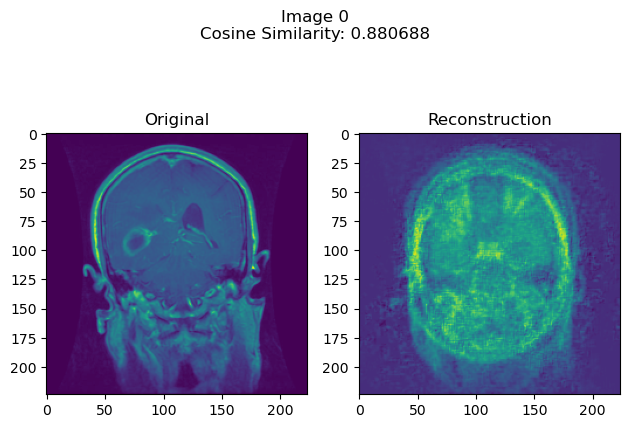

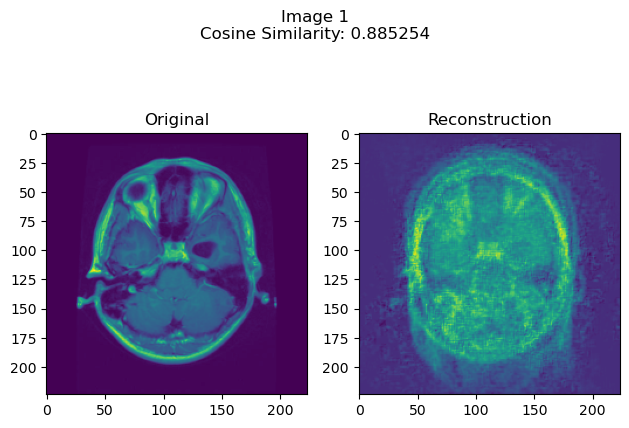

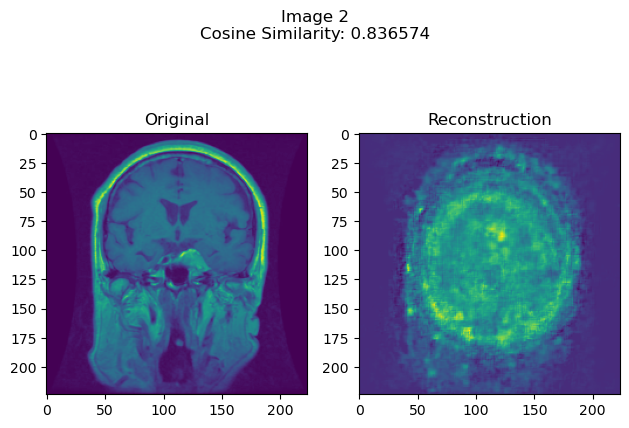

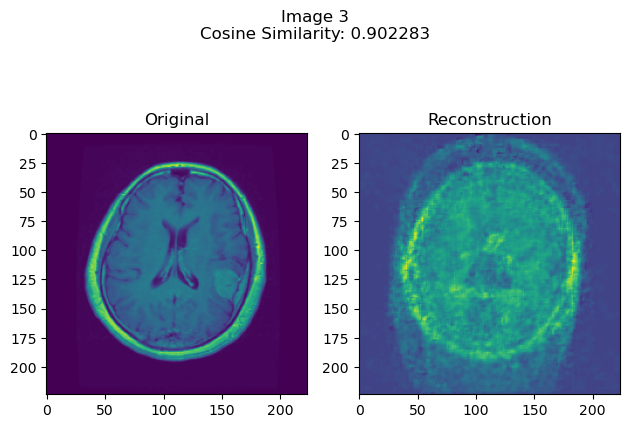

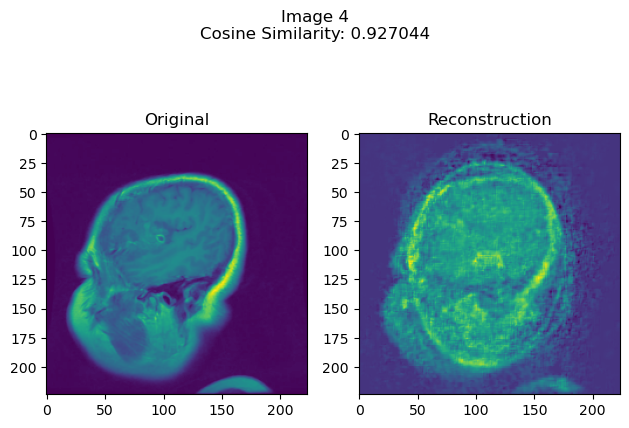

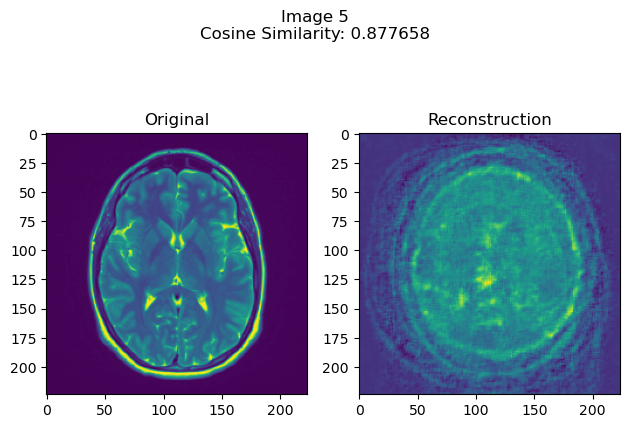

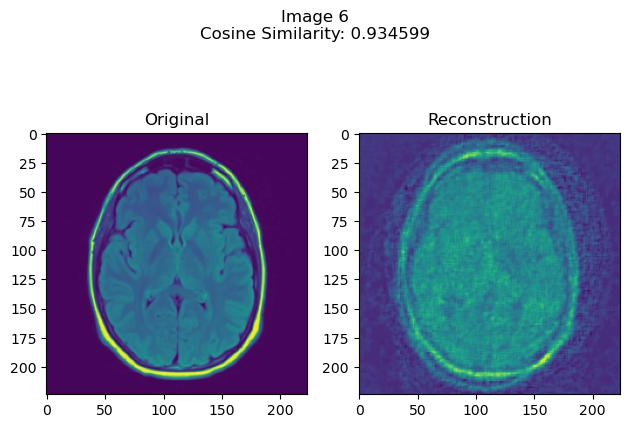

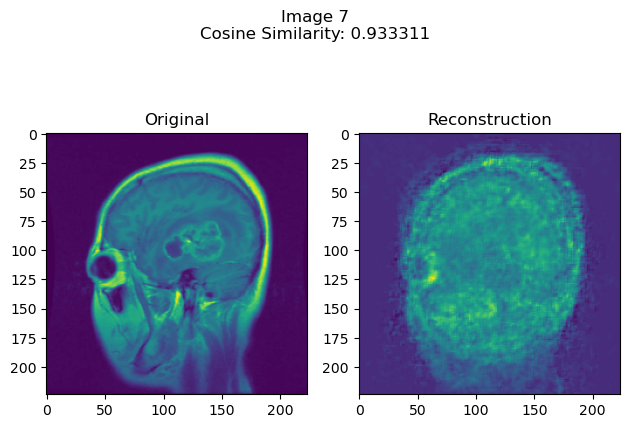

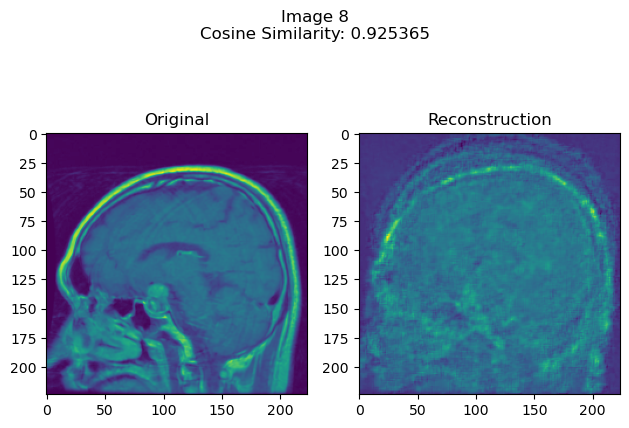

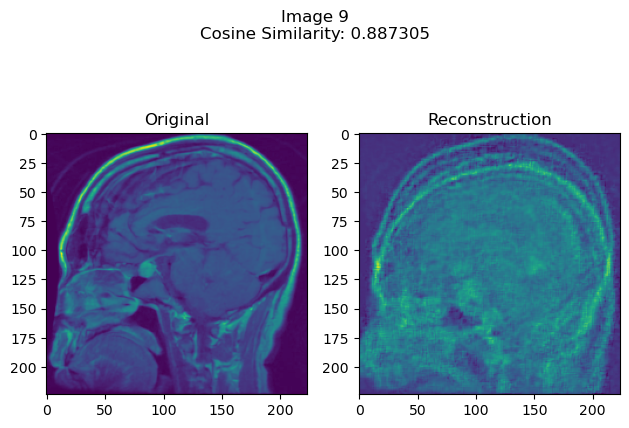

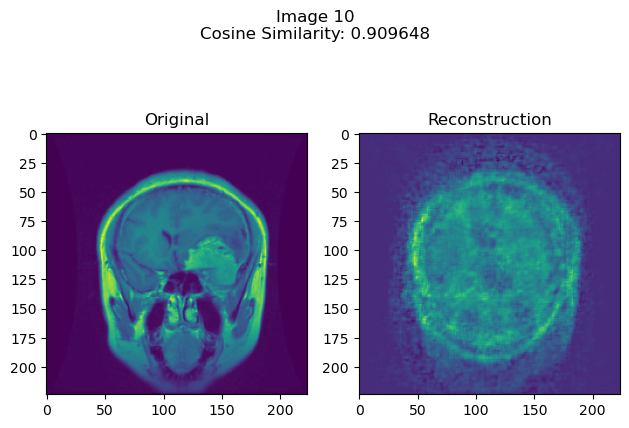

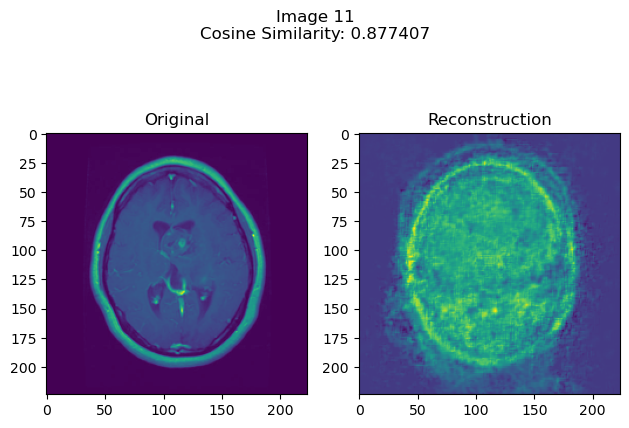

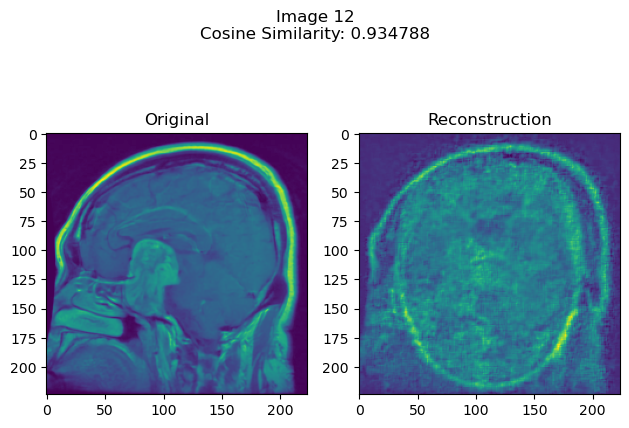

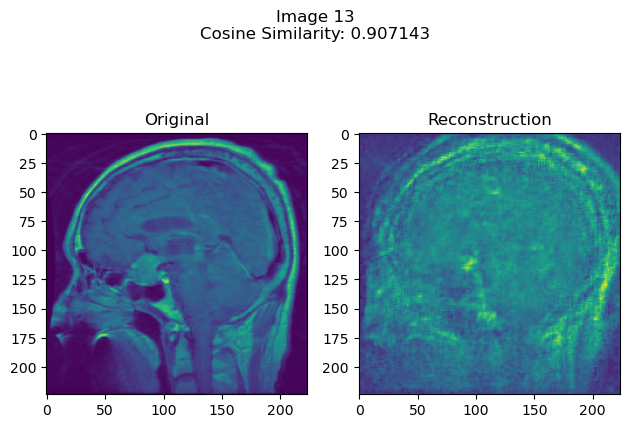

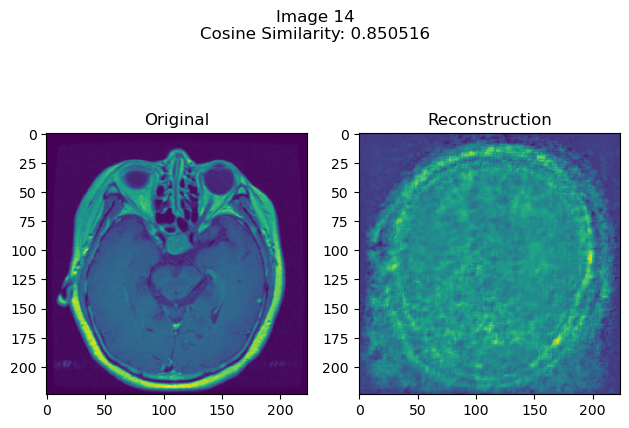

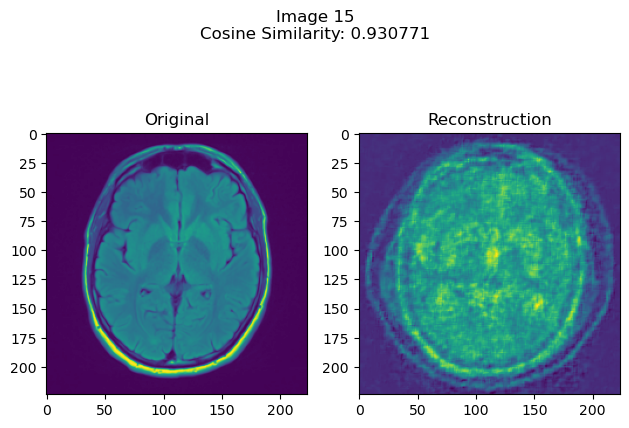

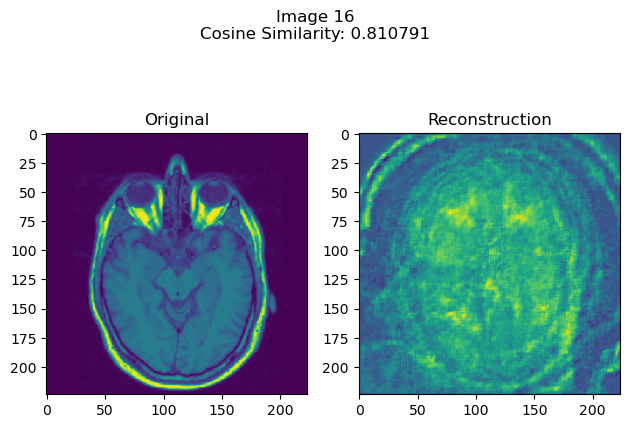

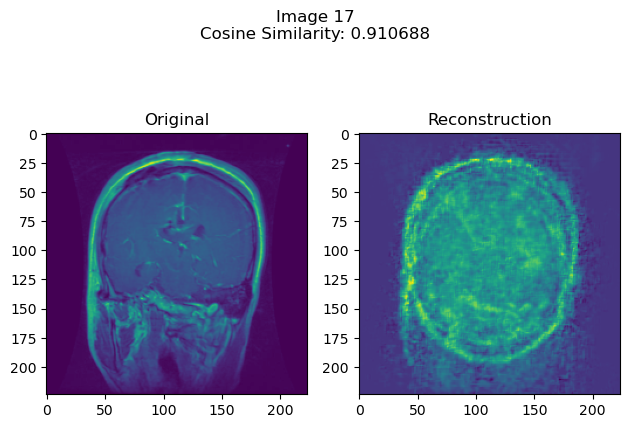

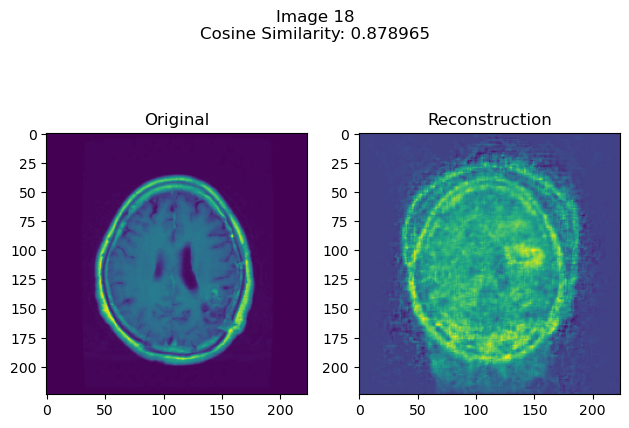

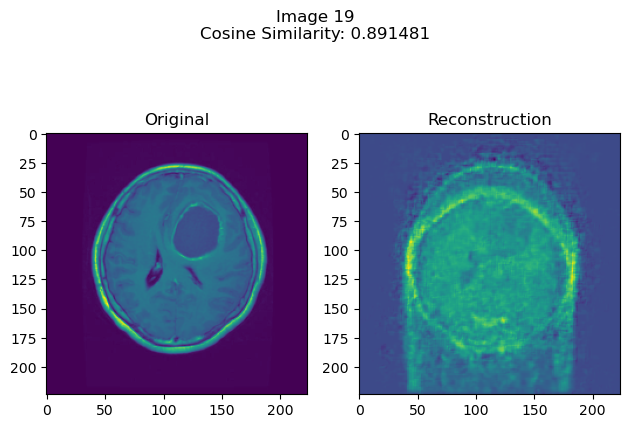

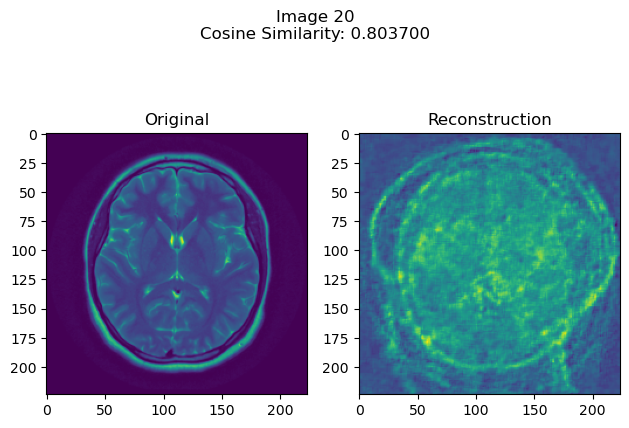

In [22]:
model.eval()
for idx, (code, _, img) in enumerate(train_mem_dataset):
    with torch.no_grad():
        img_recon = model.forward_transposed(code.view(1, -1))
        img_recon = img_recon.view(-1, 224, 224)
        img_recon = img_recon.to("cpu")
        img = img.to("cpu")
        cos0 = nn.CosineSimilarity(dim=0)
        cosine_similarity = cos0(img.reshape(-1), img_recon.reshape(-1))

        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        plt.suptitle("Image {}\nCosine Similarity: {:.6f}".format(idx, cosine_similarity))
        ax[0].imshow(img.permute(1, 2, 0))
        ax[0].set_title("Original")
        ax[1].imshow(img_recon.permute(1, 2, 0))
        ax[1].set_title("Reconstruction")
        plt.show()
        if idx > 19:
            break

It does not do so well unfortunately

In [23]:
save_path = "./models/brain2_cnn_epoch_{}_memorize_True_p_10_loss_mse_chunk_0_shuffled.pt".format(num_epochs)
save_path

'./models/brain2_cnn_epoch_100_memorize_True_p_10_loss_mse_chunk_0_shuffled.pt'

In [24]:
torch.save(model.state_dict(), save_path)